In [1]:
from lib.defaults import Main
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import json
import torch
from torch import optim
import torch.nn as nn
import sys
from lib.plotting import plot_out

In [2]:
angle_i = -36
angle_f = 180. + 36
radius = 0.2
num_reach_combinations = 8 
angle = np.deg2rad(np.linspace(angle_i, angle_f, num_reach_combinations))
dt = Main().sampling_dt

# Constants
L1 = 0.3
L2 = 0.33
I1 = 0.025
I2 = 0.045
M1 = 1.4
M2 = 1.0
B11 = 0.05
B12 = 0.025
B21 = 0.025
B22 = 0.05
S1 = 0.11
S2 = 0.16
theta1 = np.deg2rad(10) # Initial theta
joint_x = L1 * np.cos(theta1)
theta2 = np.arccos(-joint_x / L2) - theta1
THETA0 = np.array([theta1, 0, theta2, 0])
np.rad2deg(theta2)

143.54438871285726

In [3]:
# position y
def hand_of(theta):
    joint_x = L1 * np.cos(theta[0])
    joint_y = L1 * np.sin(theta[0])
    joint_x_dot = -L1 * theta[1] * np.sin(theta[0])
    joint_y_dot = L1 * theta[1] * np.cos(theta[0])
    z = theta[0] + theta[2]
    zdot = theta[1] + theta[3]
    return np.array([joint_x + L2 * np.cos(z),
                     joint_y + L2 * np.sin(z),
                     joint_x_dot - L2 * zdot * np.sin(z),
                     joint_y_dot + L2 * zdot * np.cos(z)])

HAND0 = hand_of(THETA0)
HAND0

array([ 0.        ,  0.19911089, -0.        ,  0.        ])

In [4]:
def speed_profile(t, tau_reach):
    def bell(t):        
        t = t / tau_reach
        return t**2 * np.exp(-(t**2) / 2)
    z = bell(tau_reach * np.sqrt(2))
    return 1. / z * bell(t)

In [5]:
ca = np.cos(angle)
sa = np.sin(angle)
def straight_reach(dt, duration, radius,tau_reach):
    n_bins = int(duration / dt)
    
    def hand_traj(peak_speed):
        hand = np.zeros((n_bins, 4, num_reach_combinations))
        hand[0] = HAND0[:,None]@np.ones((1,num_reach_combinations))

        for t in range(1, n_bins):
            radial_speed = peak_speed * speed_profile(dt * t,tau_reach)
            x1_dot = ca * radial_speed
            x2_dot = sa * radial_speed
            hand[t] = np.array([hand[t-1,0,:] + dt*x1_dot, hand[t-1,1,:] + dt*x2_dot, x1_dot, x2_dot])

        return hand

    def search_peak(peak_speed):
        hand_traj_current = hand_traj(peak_speed)
        final = hand_traj_current[-1]
        achieved_radius = np.sqrt((final[0] - HAND0[0])**2 + (final[1] - HAND0[1])**2)
        return np.sum((achieved_radius - radius)**2)
    
    result = minimize(search_peak, 1.5)
    return result.x[0]

In [6]:
def generate_velocity(tau_reach,range_t,p):
    n_bins = len(range_t)
    vel = np.zeros((n_bins, 2, num_reach_combinations)) 
    vx = p *speed_profile(range_t,tau_reach)[:,None] @ ca[None,:] 
    vy = p *speed_profile(range_t,tau_reach)[:,None] @ sa[None,:]
    vel[:,0,:] = vx
    vel[:,1,:] = vy
    return vel

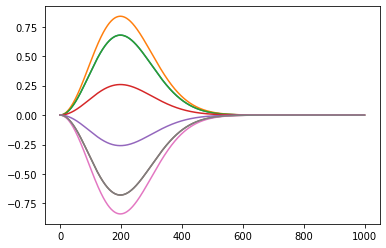

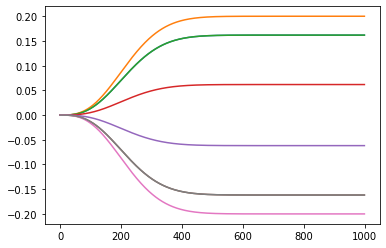

In [7]:
tau_reach = 0.14
duration = 1
velocity = []

p=straight_reach(dt, duration, radius, tau_reach)
range_t = np.arange(0,duration,dt)  
n_bins = len(range_t)

vel = generate_velocity(tau_reach,range_t,p)

plt.plot(vel[:,0,:])
plt.show()

# generate hand trajectory
hand = np.zeros((n_bins, 2, num_reach_combinations)) 
for t in range(1, n_bins):
    hand[t,0] = hand[t-1,0] + dt*vel[t-1,0]
    hand[t,1] = hand[t-1,1] + dt*vel[t-1,1]
hand[:,0] = hand[:,0]+HAND0[0]
hand[:,1] = hand[:,1]+HAND0[1]

plt.plot(hand[:,0,:])
plt.show()

In [8]:
A1 = I1 + I2 + (M2 * L1**2)
A2 = M2 * L1 * S2
A3 = I2
b = np.array([[B11, B12], [B21, B22]])  

In [9]:
'''
H.J

I used a different strategy for torque optmization, because optimizing torque is extremely slow
Instead, I find the Pk for joint velocity, because the basic velocity shape is same
'''
def angle_traj(peak_speed):
    theta = np.zeros((n_bins, 4, num_reach_combinations))
    theta[0] = np.array([[theta1],[theta2],[0],[0]])@np.ones((1,num_reach_combinations))

    for t in range(1, n_bins):
        base_speed = speed_profile(dt * t,tau_reach)
        x1_dot = peak_speed[0] * base_speed
        x2_dot = peak_speed[1] * base_speed
        theta[t] = np.array([theta[t-1,0,:] + dt*x1_dot, theta[t-1,1,:] + dt*x2_dot, x1_dot, x2_dot])

    return theta

def hand_of(theta):
    joint_x = L1 * np.cos(theta[:,0])
    joint_y = L1 * np.sin(theta[:,0])
    joint_x_dot = -(L1 * theta[:,1] * np.sin(theta[:,0]))
    joint_y_dot = L1 * theta[:,1] * np.cos(theta[:,0])
    z = theta[:,0] + theta[:,1]
    z_dot = theta[:,1] + theta[:,3]

    x1 = joint_x + (L2 * np.cos(z))
    x2 = joint_y + (L2 * np.sin(z))
#     x1_dot = joint_x_dot - (L2 * z_dot * np.sin(z))
#     x2_dot = joint_y_dot + (L2 * z_dot * np.cos(z))

    result = np.array([x1, x2]) # (2,T,num_reach_combinations)
    
    return np.transpose(result, (1, 0, 2))


def search_peak(prms):
    peak_speed = np.reshape(prms, (2, num_reach_combinations))    
    theta = angle_traj(peak_speed)    
    hand_pred = hand_of(theta)     
    error = dt * ((hand - hand_pred)**2).sum()
    return  error 

def torque_evolution(theta):
    # given a time series of muscle activation, compute the hand trajectory
    torque_list = [] 

    for t in range(n_bins):        
        if t+1==n_bins:
            theta_dot_dot = (0-theta[t, 2:]) / dt  
        else:
            theta_dot_dot = (theta[t+1, 2:]-theta[t, 2:]) / dt  
        z = A2 * np.cos(theta[t,1])
        m = np.array([[A1 + (2.0 * z), A3 + z], [A3 + z, A3]])
        x = np.array([[z * (-theta[t,3]) * ((2.0 * theta[t,2]) + theta[t,3])], [z * (theta[t,2] ** 2)]])
        theta_dot = np.array([[theta[t,2]], [theta[t,3]]])        
        torq = m @ theta_dot_dot[:,None] + x + b @ theta_dot
        torque_list.append(torq)
    torque = np.array(torque_list)
    return torque.squeeze()

In [10]:
prms = np.ones(2*num_reach_combinations)
result = minimize(search_peak, prms)
theta = angle_traj(np.reshape(result.x, (2, num_reach_combinations)))  # (T,4,num_reach_combinations)             

In [11]:
torque_list = []                  
for i in range(num_reach_combinations):
    torq = torque_evolution(theta[:,:,i])    
    
    torque_list.append(torq)
torque = np.array(torque_list)  
torque = np.transpose(torque, (0, 2, 1))

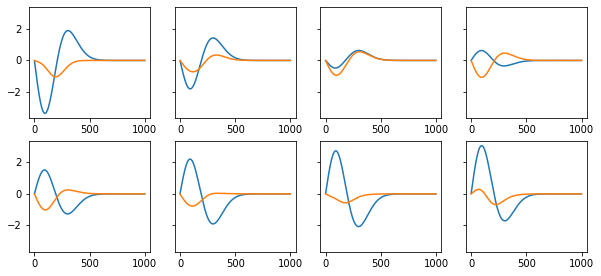

In [12]:
plot_out(torque)

In [14]:
torch.save(torch.from_numpy(torque).float(), "./torque.pt")

### python version of original codes

In [9]:
def theta_dot_dot(theta, torque):
    torque = torque[:,None]
    z = A2 * np.cos(theta[1])
    m = np.array([[A1 + (2.0 * z), A3 + z], [A3 + z, A3]])
    c = np.array([[z * (-theta[3]) * ((2.0 * theta[2]) + theta[3])], [z * (theta[2] ** 2)]])
    h = np.array([[theta[2]], [theta[3]]])

    result = np.linalg.solve(m, torque - c - np.dot(b, h))

    return result

def hand_of(theta):
    theta = theta.T
    joint_x = L1 * np.cos(theta[0])
    joint_y = L1 * np.sin(theta[0])
    joint_x_dot = -(L1 * theta[1] * np.sin(theta[0]))
    joint_y_dot = L1 * theta[1] * np.cos(theta[0])
    z = theta[0] + theta[1]
    z_dot = theta[1] + theta[3]

    x1 = joint_x + (L2 * np.cos(z))
    x2 = joint_y + (L2 * np.sin(z))
    x1_dot = joint_x_dot - (L2 * z_dot * np.sin(z))
    x2_dot = joint_y_dot + (L2 * z_dot * np.cos(z))

    result = np.array([x1, x2, x1_dot, x2_dot])

    return result

def theta_evolution(torque):
    # given a time series of muscle activation, compute the hand trajectory
    theta_list = []
    _theta = np.array([theta1,theta2,0,0])
    
    for t in range(n_bins):
        theta_dot_dot_result = theta_dot_dot(_theta, torque[t])
        
        _theta[0] = _theta[0]+ dt * _theta[2]
        _theta[1] = _theta[1]+ dt * _theta[3]
        _theta[2] = _theta[2]+ dt * theta_dot_dot_result[0]
        _theta[3] = _theta[3]+ dt * theta_dot_dot_result[1]
        
        theta_list.append(_theta)
    theta = np.array(theta_list)
    return theta

def loss(prms):
    torque = np.reshape(prms, (n_bins,2))
    theta = theta_evolution(torque)
    
    hand_pre = hand_of(theta)       
    error = dt * ((hand_tar - hand_pre)**2).sum()
    pos = torque[1:-1]
    pre = torque[:-2]
    roughness = np.linalg.norm(pos - pre)**2
    init0 = np.linalg.norm(torque[0])**2
        
    return  error + 10.0 * init0 + 2.0 * roughness

In [11]:
# horribly slow even in one condition
prms = np.zeros((2*n_bins))
# for i in range(num_reach_combinations):
for i in range(1):    
    hand_tar = np.vstack((hand[i],vel[i]))
    res = minimize(loss, prms)

KeyboardInterrupt: 